In [1]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [20]:
using StatsBase
using Random, Statistics
using Flux
using Flux, Zygote, Optimisers
using Flux: onehotbatch, onecold
using DataFrames, Plots, CSV
using Test
using CSV, DataFrames
using Measures

In [3]:
include(joinpath(@__DIR__, "..", "data", "dyck1_balanced_parentheses_gen.jl"))
using .Dyck1Data

include(joinpath(@__DIR__, "..", "data", "hrm_common_dyck1_FLUX.jl"))
using .HRMFlux

In [5]:
rng = MersenneTwister(13)

splits = Dyck1Data.make_splits(
    rng;
    Ntrain=50_000, Nval=5_000, Nmid=5_000, Nood=5_000,
    id_range=2:6,                 
    mid_range=9:10,
    ood_range=16:24,              # push OOD further out
    negative_ratio=0.5,
    strict=true,
    strict_mode=:equalcount_late   
)

# Quick cheat detectors (should NOT be 1.0)
first_is_close(xs, ys) = mean([xs[i][1] == ')' for i in eachindex(xs) if ys[i] == 0])
last_is_open(xs, ys)   = mean([xs[i][end] == '(' for i in eachindex(xs) if ys[i] == 0])
println("negatives starting with ')': ", first_is_close(splits.train_x, splits.train_y))
println("negatives ending with '(':  ",   last_is_open(splits.train_x,  splits.train_y))

# Positives balanced; negatives unbalanced
for (xs, ys, name) in ((splits.train_x, splits.train_y, "ID/train"),
                       (splits.val_x,   splits.val_y,   "ID/val"),
                       (splits.mid_x,   splits.mid_y,   "MID/test"),
                       (splits.ood_x,   splits.ood_y,   "OOD/test"))
    @assert all(Dyck1Data.is_balanced(s)  for (s,y) in zip(xs,ys) if y==1)  "$name positive not balanced"
    @assert all(!Dyck1Data.is_balanced(s) for (s,y) in zip(xs,ys) if y==0)  "$name negative still balanced"
end
println("split sanity checks passed")


negatives starting with ')': 0.8800128199991988
negatives ending with '(':  0.8800128199991988
split sanity checks passed


In [6]:

count_diff(s::AbstractString) = sum(c == '(' for c in s) - sum(c == ')' for c in s)

neg_start_rate(strings::Vector{String}, labels::Vector{Int}) =
    mean([s[1] == ')' for (s, y) in zip(strings, labels) if y == 0])

neg_end_open_rate(strings::Vector{String}, labels::Vector{Int}) =
    mean([s[end] == '(' for (s, y) in zip(strings, labels) if y == 0])

equal_count_all(strings::Vector{String}) = all(count_diff.(strings) .== 0)

function report_split(name::AbstractString, strings::Vector{String}, labels::Vector{Int})
    lengths = length.(strings)
    println("== ", name, " ==")
    println("  count: ", length(strings))
    println("  positive rate: ", round(mean(labels .== 1), digits=3))
    println("  length stats: mean=", round(mean(lengths), digits=2),
            "  min=", minimum(lengths), "  max=", maximum(lengths))
    println("  start ')', negatives: ", round(neg_start_rate(strings, labels), digits=3))
    println("  end   '(', negatives: ", round(neg_end_open_rate(strings, labels), digits=3))
    println("  equal-count (all): ", equal_count_all(strings))
    pos_bal = all(Dyck1Data.is_balanced(s)  for (s,y) in zip(strings,labels) if y==1)
    neg_unb = all(!Dyck1Data.is_balanced(s) for (s,y) in zip(strings,labels) if y==0)
    println("  positives balanced:   ", pos_bal)
    println("  negatives unbalanced: ", neg_unb)
end

report_split("ID/train", splits.train_x, splits.train_y)
report_split("ID/val",   splits.val_x,   splits.val_y)
report_split("MID/test", splits.mid_x,   splits.mid_y)
report_split("OOD/test", splits.ood_x,   splits.ood_y)


== ID/train ==
  count: 50000
  positive rate: 0.501
  length stats: mean=8.03  min=4  max=12
  start ')', negatives: 0.88
  end   '(', negatives: 0.88
  equal-count (all): true
  positives balanced:   true
  negatives unbalanced: true
== ID/val ==
  count: 5000
  positive rate: 0.492
  length stats: mean=8.01  min=4  max=12
  start ')', negatives: 0.878
  end   '(', negatives: 0.878
  equal-count (all): true
  positives balanced:   true
  negatives unbalanced: true
== MID/test ==
  count: 5000
  positive rate: 0.503
  length stats: mean=19.01  min=18  max=20
  start ')', negatives: 0.567
  end   '(', negatives: 0.567
  equal-count (all): true
  positives balanced:   true
  negatives unbalanced: true
== OOD/test ==
  count: 5000
  positive rate: 0.503
  length stats: mean=39.87  min=32  max=48
  start ')', negatives: 0.588
  end   '(', negatives: 0.588
  equal-count (all): true
  positives balanced:   true
  negatives unbalanced: true


In [7]:

# Phase-B train pool (ID pool) comes directly from splits.train_x / train_y (id_range)
x_tr_B, y_tr_B = splits.train_x, splits.train_y

# Phase-A train pool is the subset with n in 2:4 (n = length/2)
function filter_by_half_length(xs::Vector{String}, ys::Vector{Int}, n_rng::UnitRange{Int})
    keep = [(length(s) ÷ 2) in n_rng for s in xs]
    return xs[keep], ys[keep]
end
x_tr_A, y_tr_A = filter_by_half_length(splits.train_x, splits.train_y, 2:4)


x_te_ID, y_te_ID = filter_by_half_length(splits.val_x, splits.val_y, 2:4)  # ID like your Boolean setup
x_te_M,  y_te_M  = splits.mid_x, splits.mid_y                              # MID per your make_splits ranges
x_te_O,  y_te_O  = splits.ood_x, splits.ood_y                              # OOD per your make_splits ranges


expr_tr_A   = x_tr_A
expr_tr_B   = x_tr_B
expr_te_ID  = x_te_ID
expr_te_MID = x_te_M
expr_te_OOD = x_te_O

# Tokenize/pad into (L, B) integer matrices; '('to 1, ')' to 2, PAD  to 3 
pad_id = 3
to_ids(xs::Vector{String}) = Dyck1Data.pad_sequences(Dyck1Data.batch_tokenize(xs); pad_id=pad_id)

Xids_tr_A  = to_ids(x_tr_A)
Xids_tr_B  = to_ids(x_tr_B)
Xids_te_ID = to_ids(x_te_ID)
Xids_te_M  = to_ids(x_te_M)
Xids_te_O  = to_ids(x_te_O)

# Positional bound for H (add 1 for CLS inside the H input)
POS_L_MAX = maximum((size(Xids_tr_A,1), size(Xids_tr_B,1),
                     size(Xids_te_ID,1), size(Xids_te_M,1), size(Xids_te_O,1))) + 1


49

In [10]:
# All negatives starting with ')' would indicate triviality; this should be < 1.0
first_char_is_close(xs, ys) = mean([xs[i][1] == ')' for i in eachindex(xs) if ys[i] == 0])

# All negatives ending with '(' would indicate triviality; this should be < 1.0
last_char_is_open(xs, ys)  = mean([xs[i][end] == '(' for i in eachindex(xs) if ys[i] == 0])

println("negatives starting with ')': ", first_char_is_close(splits.train_x, splits.train_y))
println("negatives ending with '(':  ", last_char_is_open(splits.train_x, splits.train_y))


negatives starting with ')': 0.8800128199991988
negatives ending with '(':  0.8800128199991988


In [11]:
# fraction of negatives whose first violation occurs "late"
function first_violation_fraction_late(xs, ys; min_frac=0.7)
    late = 0; total = 0
    for (s, y) in zip(xs, ys)
        y == 0 || continue
        d = Dyck1Data._prefix_depths(s)
        # earliest index where depth becomes negative (d[k] < 0)
        fv = findfirst(<(0), d)  
        fv === nothing && continue
        total += 1
        if fv >= ceil(Int, min_frac*length(s))
            late += 1
        end
    end
    return total == 0 ? 0.0 : late/total
end

println("Late-violation rate (train): ", first_violation_fraction_late(splits.train_x, splits.train_y))
println("Late-violation rate (OOD):   ", first_violation_fraction_late(splits.ood_x,   splits.ood_y))


Late-violation rate (train): 0.11998718000080125
Late-violation rate (OOD):   0.412308930008045


In [17]:
# Dyck-1 HRM: H+L vs H+H

VARIABLE_COUNT = 6          # (not used for Dyck; kept only for analogy)

N_A   = 5_000   # Train Phase A (n = 2..4)
N_B   = 10_000  # Train Phase B (n = 2..6)
N_ID  = 1_000   # Test ID  (n = 2..4)
N_MID = 1_000   # Test MID (n = 5..6)
N_OOD = 1_000   # Test OOD (n = 7..8)

epochs_A = 10              # Phase-A epochs
epochs_B = 20              # Phase-B epochs
total_epochs = epochs_A + epochs_B

Random.seed!(13)
rng = MersenneTwister(13)

# cosine mixing schedule A->B (same spirit as your Boolean code)
const MIN_MIX_IN_B = 0.10
const MAX_MIX_IN_B = 0.60
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] to [0,1]


# strings -> (L, B) integer matrices with padding
# '(' -> 1, ')' -> 2, PAD -> 3  (embedding indices must be >= 1)
pad_id = 3

to_ids(xs::Vector{String}) =
    Dyck1Data.pad_sequences(Dyck1Data.batch_tokenize(xs); pad_id=pad_id)

Xids_tr_A  = to_ids(x_tr_A)
Xids_tr_B  = to_ids(x_tr_B)
Xids_te_ID = to_ids(x_te_ID)
Xids_te_M  = to_ids(x_te_M)
Xids_te_O  = to_ids(x_te_O)

# positional bound for H block (add 1 for CLS we prepend)
L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)
POS_L_MAX = max(L_A, L_B, L_ID, L_MID, L_OOD) + 1

# HRM config and model builds (H+L and H+H)
cfg = (
    d_in   = 0,
    d_hid  = 96,
    d_out  = 1,
    N      = 3,            # outer HRM cycles per sequence  (kept as in Boolean)
    T      = POS_L_MAX,    # length bound for positional encodings
    batch  = 32,
    lr     = 5e-5,         # match Boolean default; you can use 1e-3 if you want faster convergence
    num_tokens = 3,        # '('=1, ')'=2, PAD=3
    d_embed    = 128,
    l_heads    = 4,
    l_ff_mult  = 6,
    h_heads    = 4,
    h_ff_mult  = 6,
    dropout    = 0.1,
    pad_id     = pad_id
)

# H+L: L has no PE, H has sinusoidal PE
models_HL = HRMFlux.build_models(cfg;
    l_positional_encoding_kind = :none,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX
)

# H+H: L and H both sinusoidal PE
models_HH = HRMFlux.build_models(cfg;
    l_positional_encoding_kind = :sinusoidal,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX
)

# keep PAD embedding column neutral (zero) to avoid length bias
function freeze_pad!(models, pad_id::Int)
    if hasproperty(models, :tok_emb) && models.tok_emb !== nothing
        models.tok_emb.weight[:, pad_id] .= 0f0
    end
end
freeze_pad!(models_HL, pad_id)
freeze_pad!(models_HH, pad_id)

# batchers (same bucket-by-length idea you used)

function each_minibatch_bucketed(X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer};
                                 batch::Int, buckets::Int=6, pad_id::Int, rng::AbstractRNG=Random.GLOBAL_RNG)
    L, N = size(X)
    lens = fill(L, N)
    @inbounds for i in 1:N, t in 1:L
        if X[t, i] == pad_id
            lens[i] = t - 1
            break
        end
    end
    order  = sortperm(1:N, by=i->lens[i])
    groups = Iterators.partition(order, max(1, ceil(Int, N/buckets)))
    out = Vector{Tuple{Matrix{Int}, Vector{Int}}}()
    for g in groups
        idx = collect(g); Random.shuffle!(rng, idx)
        for k in 1:batch:length(idx)
            sel = idx[k:min(k+batch-1, length(idx))]
            push!(out, (X[:, sel], y[sel]))
        end
    end
    return out
end

function each_minibatch_mixed(XA, yA, XB, yB; batch::Int, pB::Float64, buckets::Int, pad_id::Int, rng::AbstractRNG=Random.GLOBAL_RNG)
    itA = each_minibatch_bucketed(XA, yA; batch=batch, buckets=buckets, pad_id=pad_id, rng=rng)
    itB = each_minibatch_bucketed(XB, yB; batch=batch, buckets=buckets, pad_id=pad_id, rng=rng)
    ia = 1; ib = 1
    out = Vector{Tuple{Matrix{Int}, Vector{Int}}}()
    while ia <= length(itA) || ib <= length(itB)
        useB = rand(rng) < pB
        if useB && ib <= length(itB)
            push!(out, itB[ib]); ib += 1
        elseif ia <= length(itA)
            push!(out, itA[ia]); ia += 1
        elseif ib <= length(itB)
            push!(out, itB[ib]); ib += 1
        end
    end
    return out
end


# loss and metrics (logit-BCE + accuracy)
logit_bce(ŷ, y::Vector{Int}) = Flux.Losses.logitbinarycrossentropy(vec(ŷ), Float32.(y))
accuracy(ŷ, y::Vector{Int})  = mean((σ.(vec(ŷ)) .>= 0.5) .== (y .== 1))

function batch_loss(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    B = size(x_batch, 2)
    low_state, high_state = HRMFlux.init_states(B, cfg.d_hid)
    ŷ, _, _ = HRMFlux.run_sequence_segment!(models, x_batch, low_state, high_state; N=cfg.N, cfg=cfg)
    return logit_bce(ŷ, y_batch)
end

function evaluate_matrix(models, X::AbstractMatrix{<:Integer}, y::Vector{Int}, cfg; batch_size::Int=256)
    total_acc, total_n = 0.0, 0
    N = size(X, 2)
    for k in 1:batch_size:N
        sel = k:min(k+batch_size-1, N)
        xb = X[:, sel]
        yb = y[sel]
        B  = size(xb, 2)
        low_state, high_state = HRMFlux.init_states(B, cfg.d_hid)
        ŷ, _, _ = HRMFlux.run_sequence_segment!(models, xb, low_state, high_state; N=cfg.N, cfg=cfg)
        total_acc += mean((σ.(vec(ŷ)) .>= 0.5) .== (yb .== 1)) * B
        total_n   += B
    end
    return total_acc / total_n
end


"Half-length bins: n = length(s)/2 (direct analogue to 'depth' bins in Boolean)."
function accuracy_by_half_length(models, Xids, y, xs::Vector{String}; cfg, batch_size=256)
    ns = Int[length(s) ÷ 2 for s in xs]  # since Dyck-1 strings are even-length
    mp = Dict{Int, Vector{Int}}()
    for (i, n) in enumerate(ns)
        push!(get!(mp, n, Int[]), i)
    end
    out = Dict{Int,Float64}()
    for (n, idx) in sort(collect(mp); by=first)
        out[n] = evaluate_matrix(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end

mutable struct TrainLog
    name::String
    epoch::Vector{Int}
    pB::Vector{Float64}
    loss::Vector{Float64}
    acc_id::Vector{Float64}
    acc_mid::Vector{Float64}
    acc_ood::Vector{Float64}
end
newlog(name::String) = TrainLog(name, Int[], Float64[], Float64[], Float64[], Float64[], Float64[])
function push_epoch!(L::TrainLog; epoch, pB, loss, acc_id, acc_mid, acc_ood)
    push!(L.epoch, epoch); push!(L.pB, pB); push!(L.loss, loss)
    push!(L.acc_id, acc_id); push!(L.acc_mid, acc_mid); push!(L.acc_ood, acc_ood)
end

# train/eval loop (used for both H+L and H+H)
function train!(name::String, models, Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B,
                Xids_te_ID, y_te_ID, Xids_te_M, y_te_M, Xids_te_O, y_te_O,
                xs_ID, xs_MID, xs_OOD, cfg;
                epochs_A::Int, epochs_B::Int, rng::AbstractRNG)

    log = newlog(name)
    base_lr = cfg.lr
    # opt = Optimisers.Adam(base_lr)
    # opt_state = Optimisers.setup(opt, models)


    if isdefined(Optimisers, :AdamW)
        opt = Optimisers.OptimiserChain(
            Optimisers.ClipNorm(1.0),
            Optimisers.AdamW(base_lr, (0.9, 0.999), 1e-4)
        )
    else
        opt = Optimisers.OptimiserChain(
            Optimisers.ClipNorm(1.0),
            Optimisers.Adam(base_lr)
        )
    end

    opt_state = Optimisers.setup(opt, models)

    @info "$name Curriculum: epochs_A=$epochs_A epochs_B=$epochs_B  MIN_MIX_IN_B=$MIN_MIX_IN_B"

    for epoch in 1:(epochs_A + epochs_B)
        pB = (epoch <= epochs_A) ? 0.0 :
             (MIN_MIX_IN_B + (MAX_MIX_IN_B - MIN_MIX_IN_B) * cosine01((epoch - epochs_A) / epochs_B))

        total_loss = 0.0; batches = 0

        if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == (epochs_A+epochs_B)
            @info "$name epoch=$epoch : pB=$(round(pB, digits=3))"
        end

        for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                             batch=cfg.batch, pB=pB, buckets=6, pad_id=cfg.pad_id, rng=rng)
            freeze_pad!(models, cfg.pad_id)

            L, back = Zygote.pullback(m -> batch_loss(m, xb, yb, cfg), models)
            grads = back(one(L))[1]
            opt_state, models = Optimisers.update(opt_state, models, grads)

            freeze_pad!(models, cfg.pad_id)

            total_loss += Float64(L); batches += 1
        end

        # Eval (ID / MID / OOD)
        acc_id  = evaluate_matrix(models, Xids_te_ID, y_te_ID, cfg)
        acc_mid = evaluate_matrix(models, Xids_te_M,  y_te_M,  cfg)
        acc_ood = evaluate_matrix(models, Xids_te_O,  y_te_O,  cfg)

        @info "$(name) epoch $(epoch)  loss $(round(total_loss/max(batches,1), digits=4))  " *
            "ID $(round(acc_id,digits=3))  MID $(round(acc_mid,digits=3))  OOD $(round(acc_ood,digits=3))"


        push_epoch!(log; epoch=epoch, pB=pB, loss=total_loss/max(batches,1),
                    acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood)

        if epoch % 5 == 0 || epoch == (epochs_A + epochs_B)
            ood_by_n = accuracy_by_half_length(models, Xids_te_O, y_te_O, xs_OOD; cfg=cfg)
            mid_by_n = accuracy_by_half_length(models, Xids_te_M, y_te_M, xs_MID; cfg=cfg)
            @info "$name OOD by n: $(ood_by_n)"
            @info "$name MID by n: $(mid_by_n)"
        end
    end

    return models, log
end

# H+L then H+H with identical hyper-parameters
xs_ID  = x_te_ID
xs_MID = x_te_M
xs_OOD = x_te_O

rng_HL = MersenneTwister(13)
rng_HH = MersenneTwister(13)

models_HL, log_HL = train!("H+L", models_HL,
    Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B,
    Xids_te_ID, y_te_ID, Xids_te_M, y_te_M, Xids_te_O, y_te_O,
    xs_ID, xs_MID, xs_OOD, cfg; epochs_A=epochs_A, epochs_B=epochs_B, rng=rng_HL)

models_HH, log_HH = train!("H+H", models_HH,
    Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B,
    Xids_te_ID, y_te_ID, Xids_te_M, y_te_M, Xids_te_O, y_te_O,
    xs_ID, xs_MID, xs_OOD, cfg; epochs_A=epochs_A, epochs_B=epochs_B, rng=rng_HH)



┌ Info: H+L Curriculum: epochs_A=10 epochs_B=20  MIN_MIX_IN_B=0.1
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/06_dyck1_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:216
┌ Info: H+L epoch=1 : pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/06_dyck1_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:226
┌ Info: H+L epoch 1  loss 0.0311  ID 1.0  MID 0.885  OOD 0.803
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/06_dyck1_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:247
┌ Info: H+L epoch 2  loss 0.0009  ID 1.0  MID 0.808  OOD 0.612
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/06_dyck1_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:247
┌ Info: H+L epoch 3  loss 0.0003  ID 1.0  MID 0.854  OOD 0.759
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/06_dyck1_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:247
┌ Info: H+L epoch 4  loss 

((tok_emb = Embedding(3 => 128), emb_to_hid = Dense(128 => 96, gelu_tanh), raw_to_hid = Dense(0 => 96, gelu_tanh), l_token_from_low = Dense(96 => 96), l_token_from_task = Dense(96 => 96), l_token_from_high = Dense(96 => 96), Lblk = TransformerBlock{PositionalEmbeddings.AbsolutePE{Matrix{Float32}}}(:sinusoidal, PositionalEmbeddings.AbsolutePE{Matrix{Float32}}(96, 49, Float32[-0.0041636107 0.8397238 … 0.123573124 -0.76825464; 1.0056401 0.52320457 … -0.9923355 -0.64014435; … ; 0.0028090442 0.0030195357 … 0.005694149 0.0058153; 0.9936413 0.992401 … 0.9999838 0.9999831]), MultiHeadAttention(96; nheads=4, dropout_prob=0.1), LayerNorm(96), Chain(Dense(96 => 576, gelu_tanh), Dense(576 => 96)), LayerNorm(96)), Hblk = TransformerBlock{PositionalEmbeddings.AbsolutePE{Matrix{Float32}}}(:sinusoidal, PositionalEmbeddings.AbsolutePE{Matrix{Float32}}(96, 49, Float32[-0.005885051 0.8237991 … 0.123573124 -0.76825464; 0.9852395 0.5676086 … -0.9923355 -0.64014435; … ; 0.0073005254 -0.034669336 … 0.0056941

In [28]:
using CSV, DataFrames, Plots, Measures

df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

function normalize_metric_columns!(t::DataFrame)
    nms = names(t)
    if :ID ∉ nms && :acc_id ∈ nms
        rename!(t, :acc_id => :ID)
    end
    if :MID ∉ nms && :acc_mid ∈ nms
        rename!(t, :acc_mid => :MID)
    end
    if :OOD ∉ nms && :acc_ood ∈ nms
        rename!(t, :acc_ood => :OOD)
    end
    return t
end

normalize_metric_columns!(df_HL)
normalize_metric_columns!(df_HH)

df_HL.Overall = (df_HL.ID .+ df_HL.MID .+ df_HL.OOD) ./ 3
df_HH.Overall = (df_HH.ID .+ df_HH.MID .+ df_HH.OOD) ./ 3

Plots.default(size=(900,400))

p_overall = plot(xlabel="Epoch", ylabel="Accuracy", title="Overall Accuracy (macro)",
                 legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_overall, df_HL.epoch, df_HL.Overall, lw=3, label="H+L")
plot!(p_overall, df_HH.epoch, df_HH.Overall, lw=3, ls=:solid, label="H+H")
display(p_overall); png(p_overall, "overall_vs_epoch.png")

p_id = plot(xlabel="Epoch", ylabel="Accuracy", title="In-Distribution (ID) Accuracy",
            legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_id, df_HL.epoch, df_HL.ID, lw=3, label="H+L ID")
plot!(p_id, df_HH.epoch, df_HH.ID, lw=3, ls=:solid, label="H+H ID")
display(p_id); png(p_id, "id_vs_epoch.png")

p_ood = plot(xlabel="Epoch", ylabel="Accuracy", title="OOD Accuracy",
             legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_ood, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p_ood, df_HH.epoch, df_HH.OOD, lw=3, ls=:solid, label="H+H OOD")
display(p_ood); png(p_ood, "ood_vs_epoch.png")

p_loss = plot(title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss",
              legend=:topright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_loss, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p_loss, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p_loss); savefig(p_loss, "LossVSEpoch.png")


ArgumentError: ArgumentError: column name "ID" not found in the data frame; existing most similar names are: "pB"

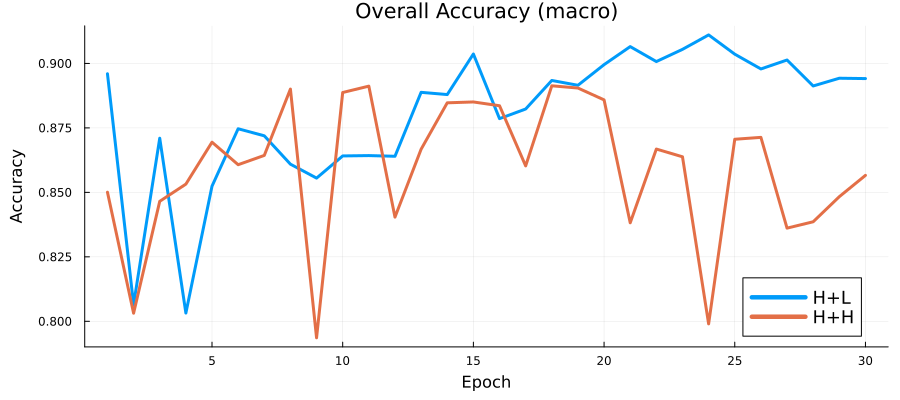

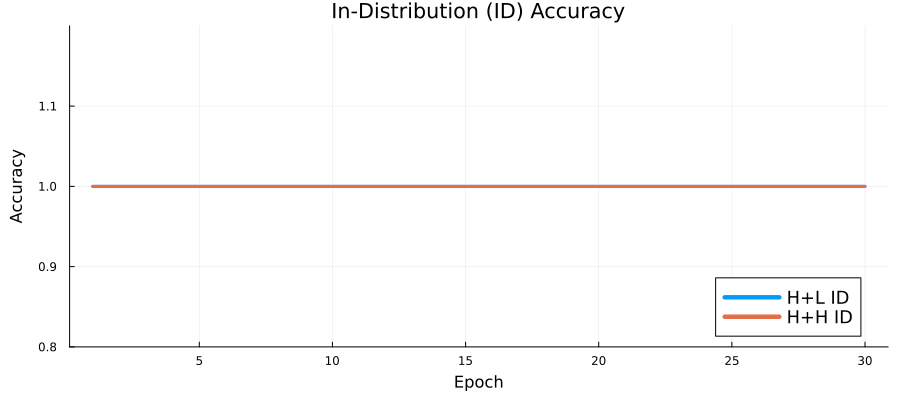

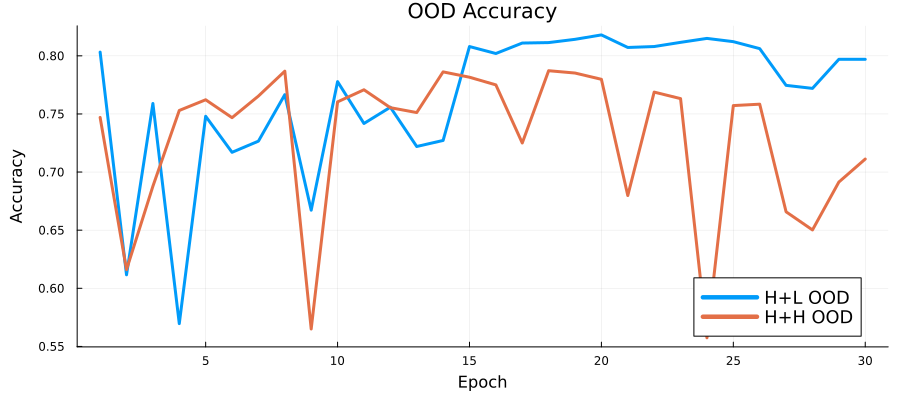

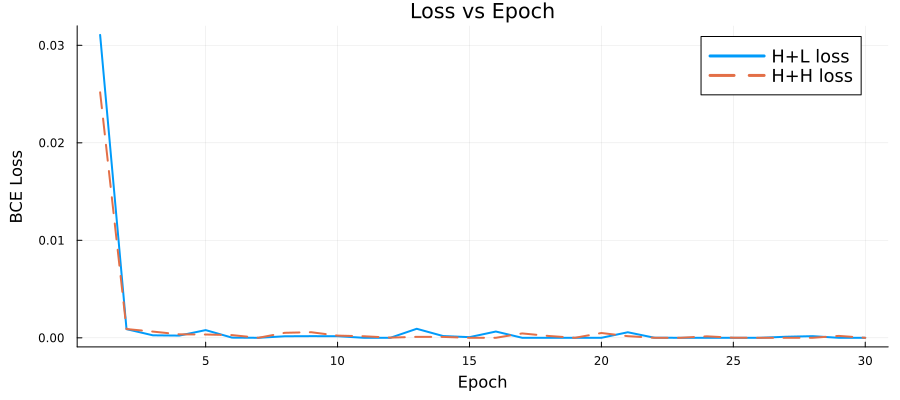

Wrote:
  hl_log.csv, hh_log.csv
  summary_last.csv, summary_peak.csv, diff_last.csv
Saved figures:
  overall_vs_epoch.png, id_vs_epoch.png, ood_vs_epoch.png, LossVSEpoch.png


In [31]:
using DataFrames, CSV, Plots, Measures, Statistics

_hasfield(T::Type, s::Symbol) = Base.hasfield(T, s)
function _getfield_or_throw(x, syms::Vector{Symbol})
    for s in syms
        if _hasfield(typeof(x), s)
            return getfield(x, s)
        end
    end
    error("None of the fields $(syms) exist on $(typeof(x)).")
end
function _getfield_or_missing(x, n::Int, syms::Vector{Symbol})
    for s in syms
        if _hasfield(typeof(x), s)
            return getfield(x, s)
        end
    end
    return fill(missing, n)
end

# Output columns: model, epoch, pB, loss, ID, MID, OOD, OOD7, OOD8
function to_dataframe_from_log(log)::DataFrame
    epochs = _getfield_or_throw(log, [:epoch, :epochs])
    n      = length(epochs)
    model  = _hasfield(typeof(log), :name)  ? getfield(log, :name)  :
             _hasfield(typeof(log), :model) ? getfield(log, :model) : "model"

    pB     = _getfield_or_throw(log, [:pB])
    loss   = _getfield_or_throw(log, [:loss])

    ID     = _getfield_or_throw(log, [:acc_id, :ID, :id])
    MID    = _getfield_or_throw(log, [:acc_mid, :MID, :mid])
    OOD    = _getfield_or_throw(log, [:acc_ood, :OOD, :ood])

    OOD7   = _getfield_or_missing(log, n, [:ood7, :OOD7])
    OOD8   = _getfield_or_missing(log, n, [:ood8, :OOD8])

    return DataFrame(
        model = fill(model, n),
        epoch = epochs,
        pB    = pB,
        loss  = loss,
        ID    = ID,
        MID   = MID,
        OOD   = OOD,
        OOD7  = OOD7,
        OOD8  = OOD8,
    )
end

df_HL = to_dataframe_from_log(log_HL)
df_HH = to_dataframe_from_log(log_HH)

CSV.write("hl_log.csv", df_HL)
CSV.write("hh_log.csv", df_HH)

function summarize_last_df(df::DataFrame)
    i = nrow(df)
    return DataFrame([(
        model = df.model[i],
        epoch = df.epoch[i],
        pB    = df.pB[i],
        loss  = df.loss[i],
        ID    = df.ID[i],
        MID   = df.MID[i],
        OOD   = df.OOD[i],
    )])
end

function summarize_peak_ood_df(df::DataFrame)
    i = argmax(df.OOD)
    return DataFrame([(
        model = df.model[i],
        epoch = df.epoch[i],
        pB    = df.pB[i],
        ID    = df.ID[i],
        MID   = df.MID[i],
        OOD   = df.OOD[i],
    )])
end

summary_last = vcat(summarize_last_df(df_HL), summarize_last_df(df_HH))
summary_peak = vcat(summarize_peak_ood_df(df_HL), summarize_peak_ood_df(df_HH))

CSV.write("summary_last.csv", summary_last)
CSV.write("summary_peak.csv", summary_peak)

# HL − HH deltas at the final epoch
HL_last = summary_last[summary_last.model .== df_HL.model[end], :]
HH_last = summary_last[summary_last.model .== df_HH.model[end], :]
diff_last = DataFrame(
    metric = ["ID","MID","OOD","loss"],
    HL     = [HL_last.ID[1], HL_last.MID[1], HL_last.OOD[1], HL_last.loss[1]],
    HH     = [HH_last.ID[1], HH_last.MID[1], HH_last.OOD[1], HH_last.loss[1]],
)
diff_last.:Δ_HL_minus_HH = diff_last.HL .- diff_last.HH
CSV.write("diff_last.csv", diff_last)

df_HL.Overall = (df_HL.ID .+ df_HL.MID .+ df_HL.OOD) ./ 3
df_HH.Overall = (df_HH.ID .+ df_HH.MID .+ df_HH.OOD) ./ 3

Plots.default(size=(900, 400))

# Overall (macro)
p_overall = plot(
    xlabel="Epoch", ylabel="Accuracy", title="Overall Accuracy (macro)",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12
)
plot!(p_overall, df_HL.epoch, df_HL.Overall, lw=3, label="H+L")
plot!(p_overall, df_HH.epoch, df_HH.Overall, lw=3, ls=:solid, label="H+H")
display(p_overall); png(p_overall, "overall_vs_epoch.png")

# ID
p_id = plot(ylims=[0.8,1.2],
    xlabel="Epoch", ylabel="Accuracy", title="In-Distribution (ID) Accuracy",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12
)
plot!(p_id, df_HL.epoch, df_HL.ID, lw=3, label="H+L ID")
plot!(p_id, df_HH.epoch, df_HH.ID, lw=3, ls=:solid, label="H+H ID")
display(p_id); png(p_id, "id_vs_epoch.png")

# OOD
p_ood = plot(
    xlabel="Epoch", ylabel="Accuracy", title="OOD Accuracy",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12
)
plot!(p_ood, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p_ood, df_HH.epoch, df_HH.OOD, lw=3, ls=:solid, label="H+H OOD")
display(p_ood); png(p_ood, "ood_vs_epoch.png")

# Loss
p_loss = plot(
    title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss",
    legend=:topright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12
)
plot!(p_loss, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p_loss, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p_loss); savefig(p_loss, "LossVSEpoch.png")

println("Wrote:")
println("  hl_log.csv, hh_log.csv")
println("  summary_last.csv, summary_peak.csv, diff_last.csv")
println("Saved figures:")
println("  overall_vs_epoch.png, id_vs_epoch.png, ood_vs_epoch.png, LossVSEpoch.png")


In [34]:
using CSV, DataFrames, Dates, Printf

df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

rename!(df_HL, Symbol.(names(df_HL)))
rename!(df_HH, Symbol.(names(df_HH)))

hascol(df::DataFrame, c::Symbol) = c ∈ names(df)

function map_name!(df::DataFrame, target::Symbol, aliases::Symbol...)
    if !hascol(df, target)
        for a in aliases
            if hascol(df, a)
                rename!(df, a => target)
                return
            end
        end
    end
end

function normalize_schema!(df::DataFrame)
    # Core columns
    map_name!(df, :epoch, :epochs, :Epoch)
    map_name!(df, :pB,    :PB, :pb)
    map_name!(df, :loss,  :Loss)

    # Metrics → canonical names
    map_name!(df, :ID,  :acc_id,  :id, :Id)
    map_name!(df, :MID, :acc_mid, :mid)
    map_name!(df, :OOD, :acc_ood, :ood)

    # Optional per-n buckets
    if !hascol(df, :OOD7)
        df.OOD7 = Vector{Union{Missing,Float64}}(undef, nrow(df)); df.OOD7 .= missing
    end
    if !hascol(df, :OOD8)
        df.OOD8 = Vector{Union{Missing,Float64}}(undef, nrow(df)); df.OOD8 .= missing
    end

    # Keep rows ordered by epoch
    if hascol(df, :epoch)
        sort!(df, :epoch)
    end
    return df
end

normalize_schema!(df_HL)
normalize_schema!(df_HH)

index_last_HL = nrow(df_HL)
index_last_HH = nrow(df_HH)

summary_last = DataFrame(
    Model = ["H+L","H+H"],
    Epoch = [df_HL.epoch[index_last_HL], df_HH.epoch[index_last_HH]],
    pB    = [df_HL.pB[index_last_HL],    df_HH.pB[index_last_HH]],
    Loss  = [df_HL.loss[index_last_HL],  df_HH.loss[index_last_HH]],
    ID    = [df_HL.ID[index_last_HL],    df_HH.ID[index_last_HH]],
    MID   = [df_HL.MID[index_last_HL],   df_HH.MID[index_last_HH]],
    OOD   = [df_HL.OOD[index_last_HL],   df_HH.OOD[index_last_HH]],
    OOD7  = [df_HL.OOD7[index_last_HL],  df_HH.OOD7[index_last_HH]],
    OOD8  = [df_HL.OOD8[index_last_HL],  df_HH.OOD8[index_last_HH]],
)

peak_index_HL = argmax(coalesce.(df_HL.OOD, -Inf))
peak_index_HH = argmax(coalesce.(df_HH.OOD, -Inf))

summary_peak = DataFrame(
    Model   = ["H+L","H+H"],
    PeakOOD = [df_HL.OOD[peak_index_HL], df_HH.OOD[peak_index_HH]],
    AtEpoch = [df_HL.epoch[peak_index_HL], df_HH.epoch[peak_index_HH]],
    pB      = [df_HL.pB[peak_index_HL],    df_HH.pB[peak_index_HH]],
    ID_at   = [df_HL.ID[peak_index_HL],    df_HH.ID[peak_index_HH]],
    MID_at  = [df_HL.MID[peak_index_HL],   df_HH.MID[peak_index_HH]],
)

Δ(x, y) = (x === missing || y === missing) ? missing : x - y

diff_last = DataFrame(
    Metric = ["Loss","ID","MID","OOD","OOD7","OOD8"],
    Delta  = [Δ(summary_last.Loss[1], summary_last.Loss[2]),
              Δ(summary_last.ID[1],   summary_last.ID[2]),
              Δ(summary_last.MID[1],  summary_last.MID[2]),
              Δ(summary_last.OOD[1],  summary_last.OOD[2]),
              Δ(summary_last.OOD7[1], summary_last.OOD7[2]),
              Δ(summary_last.OOD8[1], summary_last.OOD8[2])],
)

format_cell(x) = x === missing ? "--" : x isa AbstractFloat ? @sprintf("%.3f", x) : string(x)

isnumcol(df::DataFrame, c) = begin
    T = eltype(df[!, c])
    T <: Real || T <: Union{Missing, Real}
end

function df_to_latex_basic(df::DataFrame, caption::AbstractString="", label::AbstractString="")
    cols   = names(df)  # Symbols after rename!, but robust either way
    aligns = [isnumcol(df, c) ? "r" : "l" for c in cols]
    colspec = join(aligns, "")
    header  = join(string.(cols), " & ")

    io = IOBuffer()
    println(io, "\\begin{table}[t]")
    println(io, "\\centering")
    println(io, "\\begin{tabular}{", colspec, "}")
    println(io, "\\hline")
    println(io, header, " \\\\")
    println(io, "\\hline")
    for row in eachrow(df)
        vals = [format_cell(row[c]) for c in cols]
        println(io, join(vals, " & "), " \\\\")
    end
    println(io, "\\hline")
    println(io, "\\end{tabular}")
    if !isempty(caption); println(io, "\\caption{", caption, "}"); end
    if !isempty(label);   println(io, "\\label{", label,   "}"); end
    println(io, "\\end{table}")
    return String(take!(io))
end

function save_tex(path::AbstractString, df::DataFrame, caption::AbstractString, label::AbstractString)
    open(path, "w") do io
        print(io, df_to_latex_basic(df, caption, label))
    end
end

println(df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final"))
println(df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak"))
println(df_to_latex_basic(diff_last,    "Final-epoch differences (H+L\$-\$H+H)", "tab:diff"))

ts = Dates.format(now(), "yyyymmdd_HHMMSS")
save_tex("summary_last_$ts.tex", summary_last, "Final-epoch summary", "tab:final")
save_tex("summary_peak_$ts.tex", summary_peak, "Peak OOD summary", "tab:peak")
save_tex("diff_last_$ts.tex",    diff_last,    "Final-epoch differences (H+L\$-\$H+H)", "tab:diff")

# Optional: CSV copies of the same tables
CSV.write("summary_last_$ts.csv", summary_last)
CSV.write("summary_peak_$ts.csv", summary_peak)
CSV.write("diff_last_$ts.csv",    diff_last)


\begin{table}[t]
\centering
\begin{tabular}{lrrrrrrrr}
\hline
Model & Epoch & pB & Loss & ID & MID & OOD & OOD7 & OOD8 \\
\hline
H+L & 30 & 0.600 & 0.000 & 1.000 & 0.885 & 0.797 & -- & -- \\
H+H & 30 & 0.600 & 0.000 & 1.000 & 0.859 & 0.711 & -- & -- \\
\hline
\end{tabular}
\caption{Final-epoch summary}
\label{tab:final}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lrrrrr}
\hline
Model & PeakOOD & AtEpoch & pB & ID_at & MID_at \\
\hline
H+L & 0.818 & 20 & 0.350 & 1.000 & 0.881 \\
H+H & 0.787 & 18 & 0.273 & 1.000 & 0.887 \\
\hline
\end{tabular}
\caption{Peak OOD summary}
\label{tab:peak}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lr}
\hline
Metric & Delta \\
\hline
Loss & -0.000 \\
ID & 0.000 \\
MID & 0.027 \\
OOD & 0.086 \\
OOD7 & -- \\
OOD8 & -- \\
\hline
\end{tabular}
\caption{Final-epoch differences (H+L$-$H+H)}
\label{tab:diff}
\end{table}



"diff_last_20250909_130649.csv"

In [3]:
mutable struct TrainLog
    model::String
    epochs::Vector{Int}
    pB::Vector{Float64}
    loss::Vector{Float64}
    id::Vector{Float64}
    mid::Vector{Float64}
    ood::Vector{Float64}
    ood7::Vector{Float64}
    ood8::Vector{Float64}
end

newlog(model::String) = TrainLog(model, Int[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[])

function push_epoch!(log::TrainLog; epoch::Int, pB::Float64, loss::Float64,
                     acc_id::Float64, acc_mid::Float64, acc_ood::Float64,
                     acc7::Float64, acc8::Float64)
    push!(log.epochs, epoch)
    push!(log.pB, pB)
    push!(log.loss, loss)
    push!(log.id, acc_id)
    push!(log.mid, acc_mid)
    push!(log.ood, acc_ood)
    push!(log.ood7, acc7)
    push!(log.ood8, acc8)
    return log
end

function to_dataframe(log::TrainLog)
    n = length(log.epochs)
    return DataFrame(
        model = fill(log.model, n),
        epoch = log.epochs,
        pB    = log.pB,
        loss  = log.loss,
        ID    = log.id,
        MID   = log.mid,
        OOD   = log.ood,
        OOD7  = log.ood7,
        OOD8  = log.ood8,
    )
end

function summarize(log::TrainLog)
    n = length(log.epochs)
    i_last = n
    i_peak_ood = argmax(log.ood)
    return (
        model = log.model,
        last = (
            epoch = log.epochs[i_last],
            pB    = log.pB[i_last],
            loss  = log.loss[i_last],
            ID    = log.id[i_last],
            MID   = log.mid[i_last],
            OOD   = log.ood[i_last],
            OOD7  = log.ood7[i_last],
            OOD8  = log.ood8[i_last],
        ),
        peak_ood = (
            epoch = log.epochs[i_peak_ood],
            pB    = log.pB[i_peak_ood],
            ID    = log.id[i_peak_ood],
            MID   = log.mid[i_peak_ood],
            OOD   = log.ood[i_peak_ood],
        )
    )
end

summarize (generic function with 1 method)

In [11]:
# H+H ZONE

In [12]:
# models_hh = HRMFluxHH.build_models(cfg;
#     l_positional_encoding_kind = :sinusoidal,  # H1
#     h_positional_encoding_kind = :sinusoidal,  # H2
#     pos_L_max = POS_L_MAX)

# models_hh.tok_emb !== nothing && (models_hh.tok_emb.weight[:, PAD_ID] .= 0f0)

# bs = size(xb, 2)
# h1, h2 = HRMFluxHH.init_states(bs, cfg.d_hid)
# yhat, _, _ = HRMFluxHH.run_sequence_segment!(models_hh, xb, h1, h2; N=cfg.N, cfg=cfg)
# # compute loss, backprop, update ... same as HRM (H+L)

In [14]:
using Measures

In [25]:
CSV.write("hl_log.csv", to_dataframe(log_HL))
CSV.write("hh_log.csv", to_dataframe(log_HH))

CSV.write("summary_last.csv", summary_last)
CSV.write("summary_peak.csv", summary_peak)
CSV.write("diff_last.csv", diff_last)
# CSV.write("compact_summary.csv", df_compact)  


"diff_last.csv"

In [26]:

df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

Row,model,epoch,pB,loss,ID,MID,OOD,OOD7,OOD8
,String3,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H+H,1,0.0,0.665541,0.657,0.626,0.617,0.63,0.604
2,H+H,2,0.0,0.57742,0.719,0.663,0.642,0.632,0.652
3,H+H,3,0.0,0.469665,0.8,0.642,0.633,0.622,0.644
4,H+H,4,0.0,0.414726,0.808,0.628,0.611,0.598,0.624
5,H+H,5,0.0,0.381939,0.858,0.639,0.602,0.596,0.608
6,H+H,6,0.0,0.368428,0.861,0.653,0.647,0.632,0.662
7,H+H,7,0.0,0.355037,0.871,0.651,0.636,0.61,0.662
8,H+H,8,0.0,0.337711,0.866,0.651,0.629,0.59,0.668
9,H+H,9,0.0,0.330758,0.877,0.657,0.633,0.62,0.646


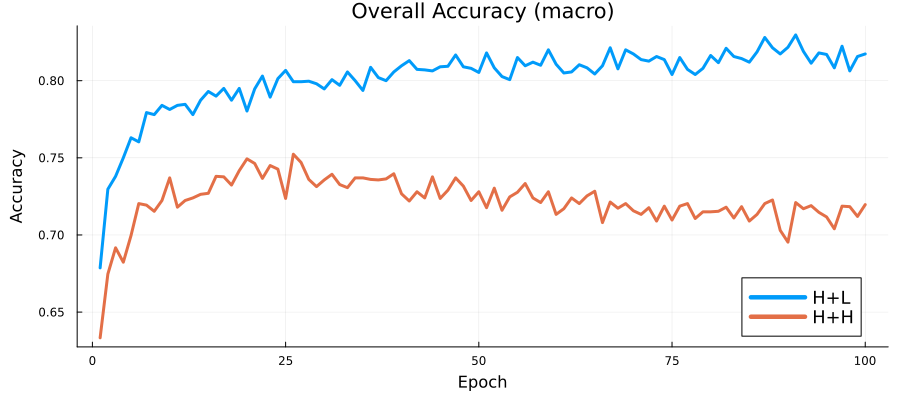

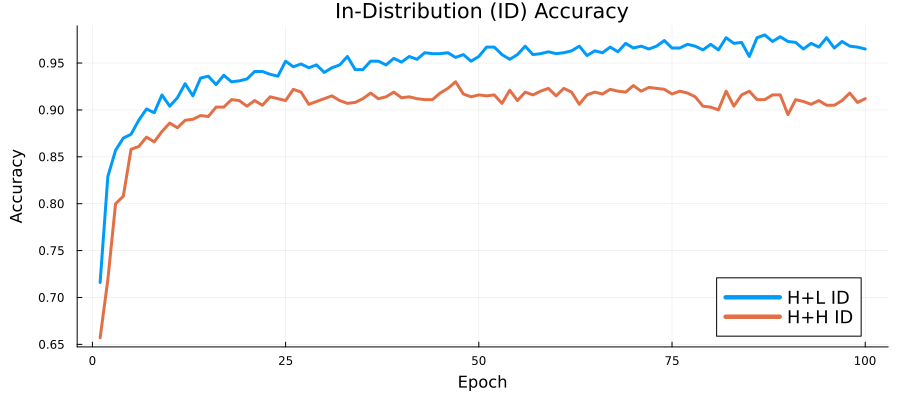

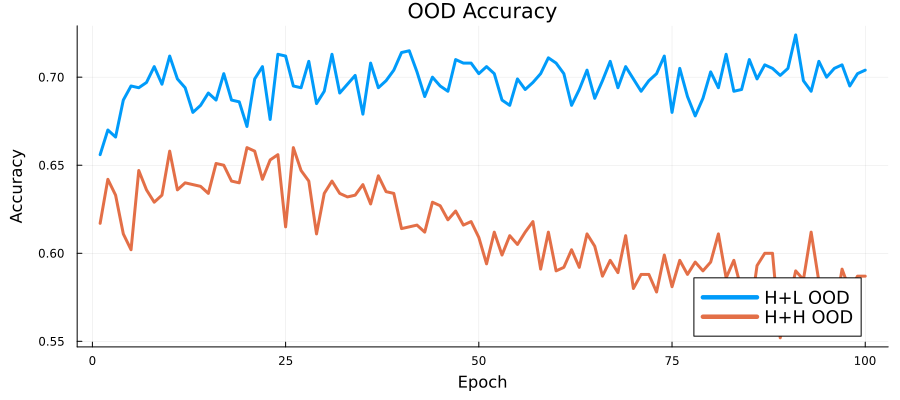

"ood_vs_epoch.png"

In [32]:


# --- Compute Overall (macro average) with a loop ---
overall_HL = Float64[]
overall_HH = Float64[]

for i in 1:nrow(df_HL)
    push!(overall_HL, (df_HL.ID[i] + df_HL.MID[i] + df_HL.OOD[i]) / 3)
end
for i in 1:nrow(df_HH)
    push!(overall_HH, (df_HH.ID[i] + df_HH.MID[i] + df_HH.OOD[i]) / 3)
end

df_HL.Overall = overall_HL
df_HH.Overall = overall_HH

# --- Simple plots ---
Plots.default(size=(900,400))

# Overall accuracy (macro)
p_overall = plot(xlabel="Epoch", ylabel="Accuracy", title="Overall Accuracy (macro)", legend=:bottomright,
                     left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_overall, df_HL.epoch, df_HL.Overall, lw=3, label="H+L")
plot!(p_overall, df_HH.epoch, df_HH.Overall, lw=3, ls=:solid, label="H+H")
display(p_overall)
png(p_overall, "overall_vs_epoch.png")

p_id = plot(xlabel="Epoch", ylabel="Accuracy", title="In-Distribution (ID) Accuracy",
            legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_id, df_HL.epoch, df_HL.ID, lw=3, label="H+L ID")
plot!(p_id, df_HH.epoch, df_HH.ID, lw=3, ls=:solid, label="H+H ID")

display(p_id)
png(p_id, "id_vs_epoch.png")

# OOD accuracy
p_ood = plot(xlabel="Epoch", ylabel="Accuracy", title="OOD Accuracy", legend=:bottomright,
                left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_ood, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p_ood, df_HH.epoch, df_HH.OOD, lw=3, ls=:solid, label="H+H OOD")
display(p_ood)
png(p_ood, "ood_vs_epoch.png")

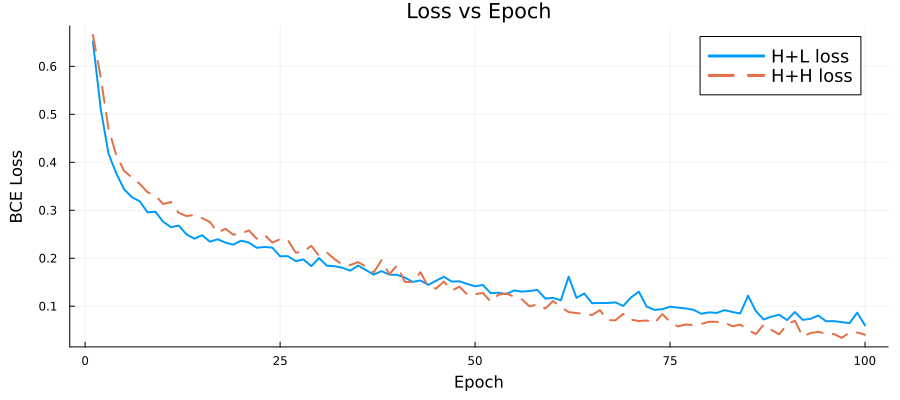

"/home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/LossVSepoc.png"

In [28]:
p4 = plot(title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss", legend=:topright,
left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p4, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p4, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p4)
savefig(p4,"LossVSepoc.png")

In [31]:
using CSV, DataFrames, Dates

# --- Load logs ---
df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

# --- Final summaries (plain indexing) ---
iL, iH = nrow(df_HL), nrow(df_HH)
summary_last = DataFrame(
    Model = ["H+L","H+H"],
    Epoch = [df_HL.epoch[iL], df_HH.epoch[iH]],
    pB    = [df_HL.pB[iL],    df_HH.pB[iH]],
    Loss  = [df_HL.loss[iL],  df_HH.loss[iH]],
    ID    = [df_HL.ID[iL],    df_HH.ID[iH]],
    MID   = [df_HL.MID[iL],   df_HH.MID[iH]],
    OOD   = [df_HL.OOD[iL],   df_HH.OOD[iH]],
    OOD7  = [df_HL.OOD7[iL],  df_HH.OOD7[iH]],
    OOD8  = [df_HL.OOD8[iL],  df_HH.OOD8[iH]],
)

iPeakHL, iPeakHH = argmax(df_HL.OOD), argmax(df_HH.OOD)
summary_peak = DataFrame(
    Model    = ["H+L","H+H"],
    PeakOOD  = [df_HL.OOD[iPeakHL], df_HH.OOD[iPeakHH]],
    AtEpoch  = [df_HL.epoch[iPeakHL], df_HH.epoch[iPeakHH]],
    pB       = [df_HL.pB[iPeakHL],    df_HH.pB[iPeakHH]],
    ID_at    = [df_HL.ID[iPeakHL],    df_HH.ID[iPeakHH]],
    MID_at   = [df_HL.MID[iPeakHL],   df_HH.MID[iPeakHH]],
)

diff_last = DataFrame(
    Metric = ["Loss","ID","MID","OOD","OOD7","OOD8"],
    Delta  = [summary_last.Loss[1]-summary_last.Loss[2],
              summary_last.ID[1]-summary_last.ID[2],
              summary_last.MID[1]-summary_last.MID[2],
              summary_last.OOD[1]-summary_last.OOD[2],
              summary_last.OOD7[1]-summary_last.OOD7[2],
              summary_last.OOD8[1]-summary_last.OOD8[2]],
)

# --- Simple LaTeX table function (using eachrow) ---
function df_to_latex_basic(df::DataFrame, caption::AbstractString="", label::AbstractString="")
    cols = names(df)
    aligns = [eltype(df[!, c]) <: Number ? "r" : "l" for c in cols]
    colspec = join(aligns, "")
    header  = join(string.(cols), " & ")

    io = IOBuffer()
    println(io, "\\begin{table}[t]")
    println(io, "\\centering")
    println(io, "\\begin{tabular}{", colspec, "}")
    println(io, "\\hline")
    println(io, header, " \\\\")
    println(io, "\\hline")
    for row in eachrow(df)
        vals = [string(row[c]) for c in cols]
        println(io, join(vals, " & "), " \\\\")
    end
    println(io, "\\hline")
    println(io, "\\end{tabular}")
    if !isempty(caption); println(io, "\\caption{", caption, "}"); end
    if !isempty(label);   println(io, "\\label{", label,   "}"); end
    println(io, "\\end{table}")
    return String(take!(io))
end

# --- Print LaTeX tables to REPL ---
println(df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final"))
println(df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak"))
println(df_to_latex_basic(diff_last,    "Final-epoch differences (H+L-H+H)", "tab:diff"))

# --- Save LaTeX tables to files ---
ts = Dates.format(now(), "yyyymmdd_HHMMSS")
open("summary_last_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final")); end
open("summary_peak_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak")); end
open("diff_last_$ts.tex","w")  do io; write(io, df_to_latex_basic(diff_last, "Final-epoch differences (H+L-H+H)", "tab:diff")); end


\begin{table}[t]
\centering
\begin{tabular}{lrrrrrrrr}
\hline
Model & Epoch & pB & Loss & ID & MID & OOD & OOD7 & OOD8 \\
\hline
H+L & 100 & 1.0 & 0.05999790815203577 & 0.965 & 0.783 & 0.704 & 0.712 & 0.696 \\
H+H & 100 & 1.0 & 0.040605767602266654 & 0.912 & 0.66 & 0.587 & 0.596 & 0.578 \\
\hline
\end{tabular}
\caption{Final-epoch summary}
\label{tab:final}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lrrrrr}
\hline
Model & PeakOOD & AtEpoch & pB & ID_at & MID_at \\
\hline
H+L & 0.724 & 91 & 0.945514773925705 & 0.972 & 0.793 \\
H+H & 0.66 & 20 & 0.0 & 0.904 & 0.684 \\
\hline
\end{tabular}
\caption{Peak OOD summary}
\label{tab:peak}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lr}
\hline
Metric & Delta \\
\hline
Loss & 0.019392140549769114 \\
ID & 0.052999999999999936 \\
MID & 0.123 \\
OOD & 0.11699999999999999 \\
OOD7 & 0.11599999999999999 \\
OOD8 & 0.118 \\
\hline
\end{tabular}
\caption{Final-epoch differences (H+L-H+H)}
\label{tab:diff}
\end{table}



324